In [2]:
for i in range(10):
    print("{0:06d}".format(i+1))

000001
000002
000003
000004
000005
000006
000007
000008
000009
000010


In [112]:
import numpy as np

pouring_or_shaking = np.load("./data/audio/pouring_or_shaking.npy").tolist()
print(len(pouring_or_shaking))
# print("pouring_or_shaking : ", pouring_or_shaking)

# filling_type = np.load("./data/audio/filling_type.npy").tolist()
# print(len(filling_type))
# print("filling_type : ", filling_type)

# folder_count = np.load("./data/audio/folder_count.npy").tolist()
# print("folder_count : ", folder_count)

# folder_count_detail =  np.load("./data/audio/folder_count_detail.npy", allow_pickle=True).tolist()
# print(len(folder_count_detail))
# print("folder_count_detail : ", folder_count_detail)

30859


In [30]:
# Mydataset.pyの内容

np.set_printoptions(threshold=100)
 
pouring_or_shaking = np.load("./data/audio/pouring_or_shaking.npy")
# print(len(pouring_or_shaking))
# print("pouring_or_shaking : ", pouring_or_shaking)

filling_type = np.load("./data/audio/filling_type.npy")
# print(len(filling_type))
# print("filling_type : ", filling_type)

folder_count = np.load("./data/audio/folder_count.npy").tolist()
print("folder_count : ", folder_count)

# folder_count_detail =  np.load("./data/audio/folder_count_detail.npy", allow_pickle=True).tolist()
# print(len(folder_count_detail))
# print("folder_count_detail : ", folder_count_detail)

label = filling_type * pouring_or_shaking
print(type(label))
print(label.shape)
print(len(label))
print("label : ", label)
print(np.unique(label))

folder_count :  [6134, 4534, 4386, 3994, 4342, 5382, 1100, 1001, 923]
<class 'numpy.ndarray'>
(31796,)
31796
label :  [0 0 0 ... 0 0 0]
[0 1 2 3]


In [31]:
for i, x in enumerate(range(10, 20)):
    print(i, x)

0 10
1 11
2 12
3 13
4 14
5 15
6 16
7 17
8 18
9 19


In [38]:
import random

random.seed(0)
a = list(range(0, 21))
train_num = 15
val_num = 5
print(a)
b = random.sample(a, train_num)
c = random.sample(a, val_num)
print("b : ", b)
print("c : ", c)
print("a == b+c ?? : ", a==sorted(b+c))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
b :  [12, 13, 1, 8, 16, 15, 6, 20, 4, 7, 5, 9, 3, 2, 11]
c :  [4, 3, 8, 17, 20]
a == b+c ?? :  False


In [42]:
6134 + 4534

10668

In [51]:
import random
# データの分割の実験
folder_count = [6134, 4534, 4386, 3994, 4342, 5382, 1100, 1001, 923]
# 0~6133 -> 6134 ~ 10667 -> ...
train_indices = []
val_indices = []
total_num = 0
for i, num in enumerate(folder_count):
    fol_indices = list(range(total_num, total_num+num))
    fol_indices = random.sample(fol_indices, num)

    # train : validation = 80 : 20
    train_size = int(num * 0.8)

    train_indices += fol_indices[0:train_size]
    val_indices += fol_indices[train_size:]

    print("total_num : ", total_num)
    print("all_size : ", len(train_indices)+len(val_indices))
    print("*******************************")
    
    total_num += num


total_num :  0
all_size :  6134
*******************************
total_num :  6134
all_size :  10668
*******************************
total_num :  10668
all_size :  15054
*******************************
total_num :  15054
all_size :  19048
*******************************
total_num :  19048
all_size :  23390
*******************************
total_num :  23390
all_size :  28772
*******************************
total_num :  28772
all_size :  29872
*******************************
total_num :  29872
all_size :  30873
*******************************
total_num :  30873
all_size :  31796
*******************************


In [55]:
print("train : ",len(train_indices))
print("validation : ", len(val_indices))

train :  25433
validation :  6363


In [59]:
print(31796 * 0.8)
# 共通する要素がないことの確認
dob = set(train_indices) & set(val_indices)
print("重複 : ", len(dob))
# 数が正しいかの確認
print("全データ数 : ", len(train_indices)+len(val_indices))

25436.800000000003
重複 :  0
全データ数 :  31796


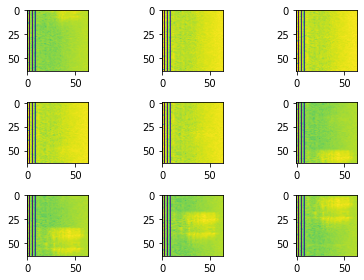

In [115]:
# mfccを読み込んでみる
# plt.subplot2gridはこれ↓
# https://stats.biopapyrus.jp/python/subplot2grid.html
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa.display
import scipy.io.wavfile

for i in range(0, 9):
    mfcc = np.load("./data/audio/mfcc/00000{}.npy".format(i+1))
    # print("type : ", type(mfcc))
    # print("shape : ", mfcc.shape)

    mfcc_ch1 = mfcc[:, :, 0]
    # print(mfcc_ch1.shape)
    plt.subplot2grid((3, 3), (i//3, i%3))
    # plt.title("log-Mel spectgrum (ch1) of 00000{}.npy".format(i+1))
    plt.imshow(mfcc_ch1)
    # plt.tick_params()
plt.tight_layout()
plt.show()

# AUdioProcessing.pyのmainの中のコードの実験

In [67]:
class AudioProcessing():
    # mfccに関するわかりやすそうな記事
    # https://aidiary.hatenablog.com/entry/20120225/1330179868
    # https://qiita.com/tmtakashi_dist/items/eecb705ea48260db0b62
    def __init__(self,sample_rate,signal,frame_length_t=0.025,frame_stride_t=0.01,nfilt =64):
        
        self.sample_rate=sample_rate
        self.signal = signal
        self.frame_length_t=frame_length_t
        self.frame_stride_t=frame_stride_t
        self.signal_length_t=float(signal.shape[0]/sample_rate)
        self.frame_length=int(round(frame_length_t * sample_rate)) #number of samples
        self.frame_step=int(round(frame_stride_t * sample_rate))
        self.signal_length = signal.shape[0]
        self.nfilt=nfilt
        self.num_frames = int(np.ceil(float(np.abs(self.signal_length - self.frame_length)) / self.frame_step))
        self.pad_signal_length=self.num_frames * self.frame_step + self.frame_length
        self.NFFT=512 # fftのサンプル数(記事中のN)
        
    def calc_MFCC(self):
        # mfccへの変換手順
        # (1) 波形を適当な長さで分割し、窓関数をかけ、fftを行う
        pre_emphasis=0.97
        emphasized_signal=np.concatenate([self.signal[0,:].reshape([1,-1]),  self.signal[1:,:] - pre_emphasis * self.signal[:-1,:]], 0)
        z = np.zeros([self.pad_signal_length - self.signal_length,8])
        pad_signal = np.concatenate([emphasized_signal, z], 0)
        indices = np.tile(np.arange(0, self.frame_length), (self.num_frames, 1)) + np.tile(np.arange(0, self.num_frames * self.frame_step, self.frame_step), (self.frame_length, 1)).T
        frames = pad_signal[indices.astype(np.int32, copy=False)]

        # (2) 窓処理を行なって、振幅スペクトルを求める
        # ハミング窓をかける
        frames=frames*np.hamming(self.frame_length).reshape(1,-1,1)
        frames=frames.transpose(0,2,1)
        mag_frames = np.absolute(np.fft.rfft(frames,self.NFFT)) # spec(記事中の)
        pow_frames = ((1.0 / self.NFFT) * ((mag_frames) ** 2)) # fscale(記事中の)

        # (3) メルフィルタバンクをかける
        filter_banks = np.dot(pow_frames, self.cal_fbank().T)
        # np.where : https://numpy.org/doc/stable/reference/generated/numpy.where.html
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
        filter_banks = 20 * np.log10(filter_banks)  # dB
        # np.transpose : https://numpy.org/doc/stable/reference/generated/numpy.transpose.html
        # -->　配列の軸の順番を入れ替える
        filter_banks =filter_banks.transpose(0,2,1)

        # (3) 離散コサイン変換を行う --> やってない : 深層学習と合わないとかなんだとか
        
        return filter_banks
           
    def cal_fbank(self):
        # おそらくメルフィルタバンクなるものを作る関数
        low_freq_mel = 0
        high_freq_mel = (2595 * np.log10(1 + (self.sample_rate / 2) / 700))  
        mel_points = np.linspace(low_freq_mel, high_freq_mel, self.nfilt + 2)  
        hz_points = (700 * (10**(mel_points / 2595) - 1)) 
        bin = np.floor((self.NFFT + 1) * hz_points / self.sample_rate)
        fbank = np.zeros((self.nfilt, int(np.floor(self.NFFT / 2 + 1))))
        for m in range(1, self.nfilt + 1):
            f_m_minus = int(bin[m - 1])   # left
            f_m = int(bin[m])             # center
            f_m_plus = int(bin[m + 1])    # right

            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        return fbank

In [86]:
audio_path = "./data/1//audio/s0_fi0_fu0_b0_l0_audio.wav"
# audio_path = "./data/1//audio/s0_fi0_fu0_b0_l1_audio.wav"
save_size = 64
sample_rate, signal = scipy.io.wavfile.read(audio_path)

print("save_size : ", save_size)
print("sample_rate : ", sample_rate)
print("signal=type : ", type(signal))
print("signal-shape ; ", signal.shape)
        
ap = AudioProcessing(sample_rate,signal,nfilt=save_size)
mfcc = ap.calc_MFCC()
print("mfcc-type : ", type(mfcc))
print("mfcc-shape : ", mfcc.shape)
mfcc_length=mfcc.shape[0]
print("mfcc_length : ", mfcc_length)


ratio_step = 0.25

f_step=int(mfcc.shape[1]*ratio_step)
print("mfcc.shape[1] : ", mfcc.shape[1])
print("f_step : ", f_step)
f_length=mfcc.shape[1]
print("f_length : ", f_length)


save_mfcc_num=int(np.ceil(float(np.abs(mfcc_length - save_size)) / f_step))
print("save_mfcc_num : ", save_mfcc_num)

save_size :  64
sample_rate :  44100
signal=type :  <class 'numpy.ndarray'>
signal-shape ;  (116940, 8)
mfcc-type :  <class 'numpy.ndarray'>
mfcc-shape :  (263, 64, 8)
mfcc_length :  263
mfcc.shape[1] :  64
f_step :  16
f_length :  64
save_mfcc_num :  13


In [93]:
import pandas as pd
count = 0
df = pd.read_csv("annotations.csv", header=0)
fileidx = 0
file_name = df.iat[fileidx, 2]
folder_num = df.iat[fileidx, 0] # container_id
start_time =  df.iat[fileidx, 9]
end_time = df.iat[fileidx, 10]
filling_type = df.iat[fileidx, 4]

# for i in range(save_mfcc_num):
#     count += 1
#     tmp_mfcc = mfcc[i*f_step:save_size+i*f_step,: ,:] # (64, 64, 8)

#     if start_time == -1:
#         pouring_or_shaking_list.append(0)
#     elif start_time/ap.signal_length_t*mfcc_length<i*f_step+f_length*0.75 and end_time/ap.signal_length_t*mfcc_length>i*f_step+f_length*0.25:
#         pouring_or_shaking_list.append(1) 
#     else:
#         pouring_or_shaking_list.append(0)
    
#     filling_type_list.append(filling_type)
#     file_idx_list.append(fileidx)
#     folder_count[folder_num-1] += 1

In [94]:
df.head()

,folder_num,num,file_name,subject,filling_type,filling_level,back,light,start,end
0,1,0,s2_fi0_fu0_b0_l1_c2,2,0,0,0,1,-1,-1
1,1,1,s0_fi2_fu2_b0_l1_c2,0,2,2,0,1,-1,-1
2,1,2,s0_fi1_fu2_b1_l0_c2,0,1,2,1,0,-1,-1
3,1,3,s1_fi3_fu2_b0_l0_c2,1,3,2,0,0,-1,-1
4,1,4,s0_fi1_fu1_b1_l0_c2,0,1,1,1,0,-1,-1


In [106]:
temp1 = pd.read_csv("annotations.csv")
temp2 = pd.read_csv("annotations_last_yaer.csv")
temp1.head()

,folder_num,num,file_name,subject,filling_type,filling_level,back,light,camera_id,start,end
0,1,0,s2_fi0_fu0_b0_l1_c2,2,0,0,0,1,2,-1,-1
1,1,1,s0_fi2_fu2_b0_l1_c2,0,2,2,0,1,2,-1,-1
2,1,2,s0_fi1_fu2_b1_l0_c2,0,1,2,1,0,2,-1,-1
3,1,3,s1_fi3_fu2_b0_l0_c2,1,3,2,0,0,2,-1,-1
4,1,4,s0_fi1_fu1_b1_l0_c2,0,1,1,1,0,2,-1,-1


In [107]:
# file_name = df.iat[fileidx, 2]
temp2.head()

,folder_num,num,file_name,subject,filling_type,filling_level,back,light,camera_id,start,end
0,1,0,s0_fi0_fu0_b0_l0_c2,0,0,0,0,0,2,-1.0,-1.0
1,1,1,s0_fi0_fu0_b0_l1_c2,0,0,0,0,1,2,-1.0,-1.0
2,1,2,s0_fi0_fu0_b1_l0_c2,0,0,0,1,0,2,-1.0,-1.0
3,1,3,s0_fi0_fu0_b1_l1_c2,0,0,0,1,1,2,-1.0,-1.0
4,1,4,s0_fi1_fu1_b0_l0_c2,0,1,1,0,0,2,2.1,5.2


In [111]:
print(temp2.iat[0, 10])
print(temp2.iat[0, 10])
len(temp2.columns)

-1.0
-1.0


11